In [1]:
import random
import csv
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from einops import einsum, rearrange, reduce

random.seed(10)

# Loading model

In [2]:
model = LanguageModel(
    "/data/public_models/huggingface/meta-llama/Meta-Llama-3-70B-Instruct",
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16,
    dispatch=True,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

# Loading data

In [3]:
variable = "0_forward_belief"

with open(f"data/bigtom/{variable}_true_belief/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    tb_data = list(reader)

with open(f"data/bigtom/{variable}_false_belief/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    fb_data = list(reader)

# Circuit Discovery

In [4]:
n_samples = 100
batch_size = 2
clean_samples = []
method_name = "0shot"

with open(f"prompt_instructions/{method_name}.txt", "r") as f:
    instructions = f.read()

for example in tb_data[: n_samples]:
    story, clean_question_raw, correct_answer, wrong_answer = example
    answers = [correct_answer, wrong_answer]
    random.shuffle(answers)

    clean_question = f"{clean_question_raw}\nChoose one of the following:\na) {answers[0]}\nb) {answers[1]}"
    corrupt_question = f"{clean_question_raw}\nChoose one of the following:\na) {answers[1]}\nb) {answers[0]}"

    clean_prompt = f"Instructions: {instructions}\nStory: {story}\nQuestion: {clean_question}\nAnswer:"
    corrupt_prompt = f"Instructions: {instructions}\nStory: {story}\nQuestion: {corrupt_question}\nAnswer:"

    if answers[0] == correct_answer:
        clean_target = " a"
        corrupt_target = " b"
    else:
        clean_target = " b"
        corrupt_target = " a"

    clean_samples.append({"clean_prompt": clean_prompt, "clean_target": clean_target, "corrupt_prompt": corrupt_prompt, "corrupt_target": corrupt_target})

# Create dataloader using clean_samples
dataset = Dataset.from_list(clean_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
def metric_fn(model, clean_target, corrupt_target):
    clean_target_token_idx = model.tokenizer(clean_target, return_tensors="pt", padding=False)["input_ids"][:, -1]
    corrupt_target_token_idx = model.tokenizer(corrupt_target, return_tensors="pt", padding=False)["input_ids"][:, -1]

    logit_diff = torch.gather(
        model.lm_head.output[:, -1], dim=-1, index=corrupt_target_token_idx.view(-1, 1)
    ) - torch.gather(
        model.lm_head.output[:, -1], dim=-1, index=clean_target_token_idx.view(-1, 1)
    )
    logit_diff = logit_diff.squeeze(-1)
    return logit_diff

In [18]:
correct, total = 0, 0
attribution_score = torch.zeros(len(dataloader), model.config.num_hidden_layers, model.config.num_attention_heads).cpu()

for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    clean_prompt = batch["clean_prompt"]
    corrupt_prompt = batch["corrupt_prompt"]
    clean_target = batch["clean_target"]
    corrupt_target = batch["corrupt_target"]

    hidden_act_clean, hidden_act_corrupt, grads = {}, {}, {}
    with model.trace(clean_prompt, scan=False, validate=False):
        for layer_idx in range(model.config.num_hidden_layers):
            head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
            hidden_act_clean[layer_idx] = head_out.cpu().save()
            grads[layer_idx] = head_out.grad.cpu().save()

        metric_clean = metric_fn(model, clean_target, corrupt_target)
        metric_clean.sum().backward()

    hidden_act_clean = {k: v.value.cpu() for k, v in hidden_act_clean.items()}
    grads = {k: v.value.cpu() for k, v in grads.items()}
    
    model.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        with model.trace(corrupt_prompt, scan=False, validate=False), torch.inference_mode():
            for layer_idx in range(model.config.num_hidden_layers):
                head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
                hidden_act_corrupt[layer_idx] = head_out.cpu().save()

            metric_corrupt = metric_fn(model, clean_target, corrupt_target)

#     total_effect = (metric_corrupt.value - metric_clean.value).detach().cpu()
    hidden_act_corrupt = {k: v.value.cpu() for k, v in hidden_act_corrupt.items()}
    
    torch.cuda.empty_cache()

    d_head = model.config.hidden_size // model.config.num_attention_heads
    with torch.no_grad(), torch.inference_mode():
        for layer_idx in range(model.config.num_hidden_layers):
            clean_state, corrupt_state, grad = hidden_act_clean[layer_idx], hidden_act_corrupt[layer_idx], grads[layer_idx]
            delta = (corrupt_state - clean_state).detach()
            score = delta * grad

            # Averaging over all batch items and analysing components only at last token position
            score = score.sum(dim=0)[-1]
            score = rearrange(score, "(n_heads d_head) -> n_heads d_head", n_heads=model.config.num_attention_heads)
            score = reduce(score, "n_heads d_head -> n_heads", "sum")
            attribution_score[batch_idx][layer_idx] = score

        del hidden_act_clean[layer_idx], hidden_act_corrupt[layer_idx], grads[layer_idx], clean_state, corrupt_state, grad, score
        torch.cuda.empty_cache()

    torch.save(attribution_score, "attribution_score.pt")

100%|██████████| 50/50 [13:44<00:00, 16.49s/it]


In [19]:
effects = attribution_score.mean(dim=0)
effects = effects.flip(0)

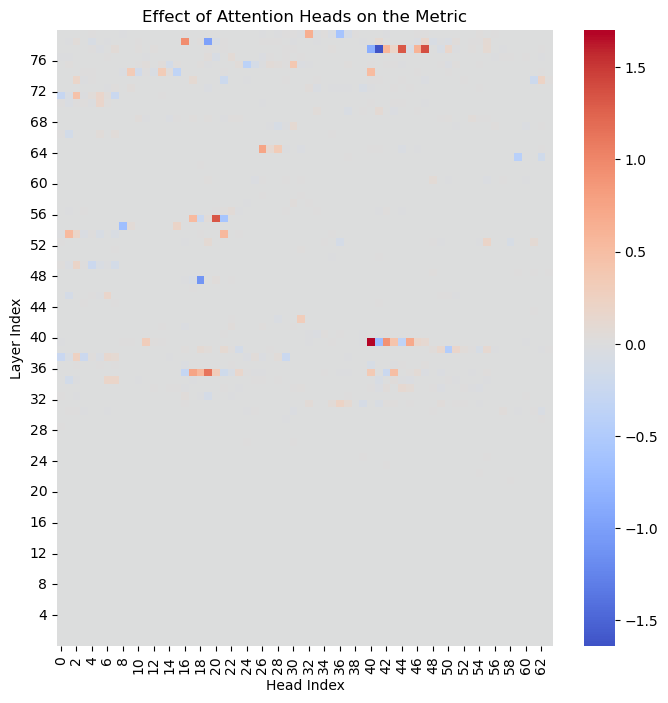

In [20]:
# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(effects, cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(ticks=list(range(4, model.config.num_hidden_layers, 4)), labels=list(range(4, model.config.num_hidden_layers, 4))[::-1])
plt.show()

In [21]:
effects = effects.flip(0)

In [29]:
k = 50
topk_heads = effects.view(-1).topk(k).indices
topk_heads = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in topk_heads]

In [30]:
for l, h in topk_heads:
    print(f"Layer {l}, Head {h}")

Layer 39, Head 40
Layer 77, Head 47
Layer 55, Head 20
Layer 77, Head 44
Layer 35, Head 19
Layer 78, Head 16
Layer 39, Head 42
Layer 35, Head 17
Layer 64, Head 26
Layer 39, Head 45
Layer 79, Head 32
Layer 77, Head 46
Layer 77, Head 42
Layer 35, Head 18
Layer 53, Head 21
Layer 55, Head 17
Layer 53, Head 1
Layer 74, Head 40
Layer 35, Head 43
Layer 71, Head 2
Layer 39, Head 43
Layer 75, Head 30
Layer 35, Head 40
Layer 74, Head 9
Layer 74, Head 13
Layer 64, Head 28
Layer 39, Head 11
Layer 35, Head 20
Layer 42, Head 31
Layer 37, Head 2
Layer 73, Head 62
Layer 31, Head 36
Layer 49, Head 2
Layer 52, Head 55
Layer 54, Head 15
Layer 34, Head 7
Layer 53, Head 2
Layer 73, Head 2
Layer 34, Head 6
Layer 77, Head 43
Layer 70, Head 5
Layer 38, Head 51
Layer 45, Head 6
Layer 71, Head 5
Layer 39, Head 46
Layer 77, Head 50
Layer 78, Head 47
Layer 35, Head 23
Layer 38, Head 49
Layer 37, Head 6
